In [5]:
%matplotlib inline
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from unwrap_error import iono
figsize = [12, 4]

proj_dir = '/Users/yunjunz/data/archives/ChileSenAT149'
os.chdir(proj_dir)
print('Go to directory', proj_dir)

mintpy_dir = os.path.join(proj_dir, 'mintpyOffset')
out_file = os.path.join(mintpy_dir, 'TS_gim_tec.pickle')

# config for GIM TEC data
gim_tec_dir = os.path.join(proj_dir, 'tec_sent1_tracks')
iono_height = 450e3  # height of ionospheric shell in m

Go to directory /Users/yunjunz/data/archives/ChileSenAT149


### 1.1 grab the geometry info

In [6]:
geom_file = os.path.join(mintpy_dir, 'inputs/geometryRadar.h5')
atr = readfile.read_attribute(geom_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
row_c = int(length / 2)
col_c = int(width / 2)
box_c = (col_c, row_c, col_c+1, row_c+1)

# geometry on the ground
head_angle = float(atr['HEADING'])
inc_angle_c = readfile.read(geom_file, datasetName='incidenceAngle', box=box_c)[0][0,0]
lat_c = readfile.read(geom_file, datasetName='latitude', box=box_c)[0][0,0]
lon_c = readfile.read(geom_file, datasetName='longitude', box=box_c)[0][0,0]

# geometry at the ionospheric shell
inc_angle = ut.incidence_angle_ground2iono_shell_along_los(inc_angle_c, iono_height=iono_height)
lat, lon = ut.lalo_ground2iono_shell_along_los(lat_c, lon_c,
                                               inc_angle=inc_angle_c,
                                               head_angle=head_angle,
                                               iono_height=iono_height)

print('heading   angle: {:.1f} deg'.format(head_angle))
print('incidence angle on the ground: {:.1f} deg'.format(inc_angle_c))
print('incidence angle at ionosphere: {:.1f} deg'.format(inc_angle))
print('SAR scene center on the ground in lat/lon: {:.1f}/{:.1f}'.format(lat_c, lon_c))
print('SAR scene center at ionosphere in lat/lon: {:.1f}/{:.1f}'.format(lat, lon))
print('SAR acquisition time UTC: {} hours'.format(float(atr['CENTER_LINE_UTC']) / 3600.))

heading   angle: -13.9 deg
incidence angle on the ground: 39.7 deg
incidence angle at ionosphere: 36.6 deg
SAR scene center on the ground in lat/lon: -21.0/-68.4
SAR scene center at ionosphere in lat/lon: -18.1/-69.2
SAR acquisition time UTC: 23.1075 hours


### 1.2 read GIM TEC and calculate the range delay

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20150624.txt.dt
distance to nearest TEC obs: 1.8 deg (199 km)


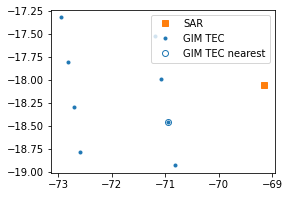

ERROR: no file found for 20150811 in: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20150811.txt.dt
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20150928.txt.dt
distance to nearest TEC obs: 1.4 deg (153 km)


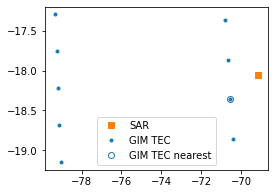

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20151022.txt.dt
distance to nearest TEC obs: 4.0 deg (427 km)


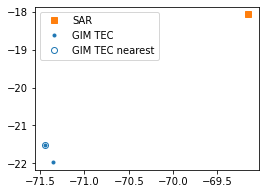

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20151115.txt.dt
distance to nearest TEC obs: 2.4 deg (263 km)


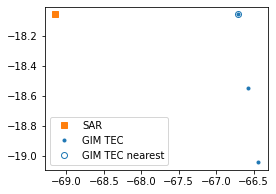

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20151209.txt.dt
distance to nearest TEC obs: 0.5 deg (50 km)


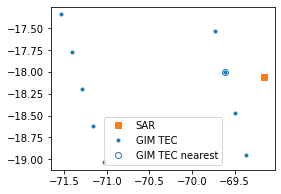

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20160102.txt.dt
distance to nearest TEC obs: 3.1 deg (336 km)


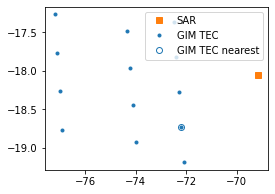

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20160126.txt.dt
distance to nearest TEC obs: 3.5 deg (382 km)


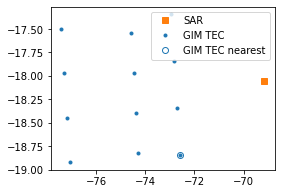

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20160314.txt.dt
distance to nearest TEC obs: 3.3 deg (359 km)


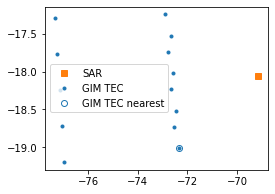

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20160407.txt.dt
distance to nearest TEC obs: 10.4 deg (1127 km)


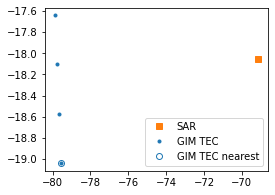

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20160501.txt.dt
distance to nearest TEC obs: 5.1 deg (551 km)


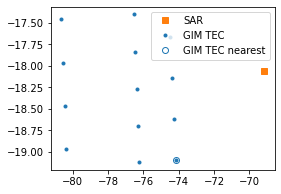

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20160525.txt.dt
distance to nearest TEC obs: 6.6 deg (711 km)


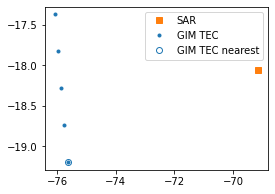

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20160712.txt.dt
distance to nearest TEC obs: 5.0 deg (545 km)


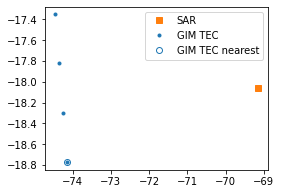

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20160805.txt.dt
distance to nearest TEC obs: 1.6 deg (171 km)


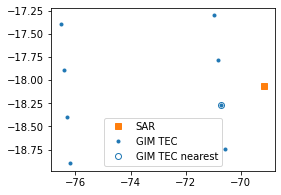

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20160829.txt.dt
distance to nearest TEC obs: 3.1 deg (336 km)


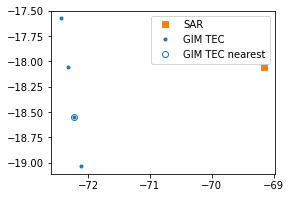

ERROR: no file found for 20160922 in: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20160922.txt.dt
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20161022.txt.dt
distance to nearest TEC obs: 0.3 deg (29 km)


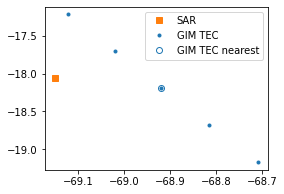

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20161115.txt.dt
distance to nearest TEC obs: 0.1 deg (8 km)


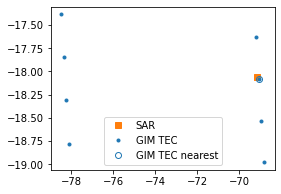

ERROR: no file found for 20161209 in: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20161209.txt.dt
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170102.txt.dt
distance to nearest TEC obs: 4.3 deg (467 km)


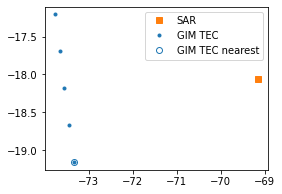

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170126.txt.dt
distance to nearest TEC obs: 0.9 deg (98 km)


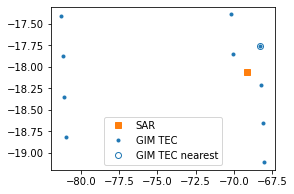

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170219.txt.dt
distance to nearest TEC obs: 4.5 deg (490 km)


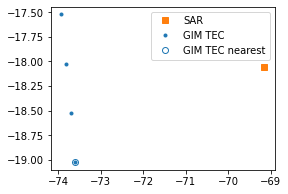

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170303.txt.dt
distance to nearest TEC obs: 2.8 deg (307 km)


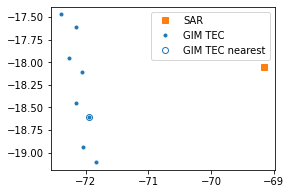

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170315.txt.dt
distance to nearest TEC obs: 1.1 deg (122 km)


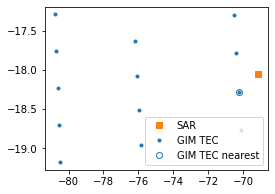

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170526.txt.dt
distance to nearest TEC obs: 1.5 deg (162 km)


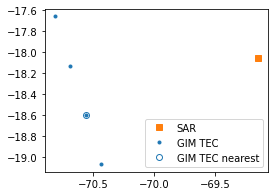

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170607.txt.dt
distance to nearest TEC obs: 2.0 deg (220 km)


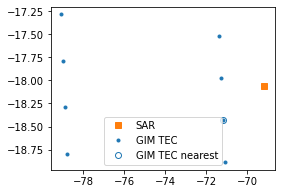

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170619.txt.dt
distance to nearest TEC obs: 8.9 deg (965 km)


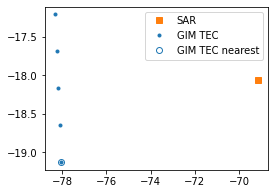

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170701.txt.dt
distance to nearest TEC obs: 4.8 deg (521 km)


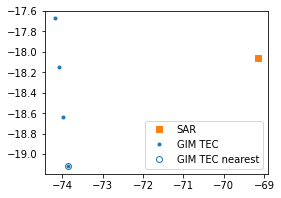

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170713.txt.dt
distance to nearest TEC obs: 3.1 deg (331 km)


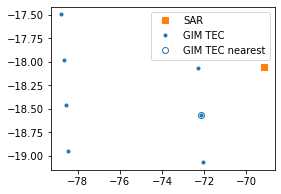

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170725.txt.dt
distance to nearest TEC obs: 1.5 deg (158 km)


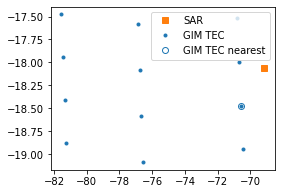

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170806.txt.dt
distance to nearest TEC obs: 6.1 deg (661 km)


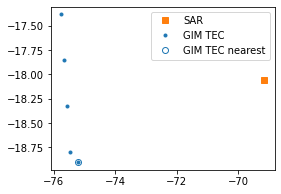

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170818.txt.dt
distance to nearest TEC obs: 3.4 deg (365 km)


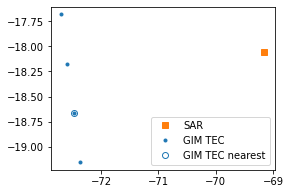

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170830.txt.dt
distance to nearest TEC obs: 1.5 deg (163 km)


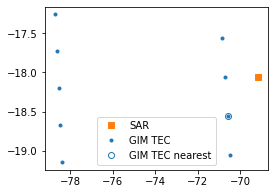

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170911.txt.dt
distance to nearest TEC obs: 9.9 deg (1069 km)


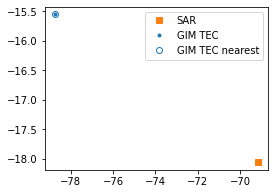

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20170923.txt.dt
distance to nearest TEC obs: 3.5 deg (376 km)


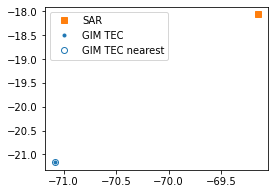

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20171005.txt.dt
distance to nearest TEC obs: 0.3 deg (28 km)


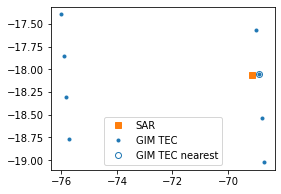

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20171017.txt.dt
distance to nearest TEC obs: 2.5 deg (271 km)


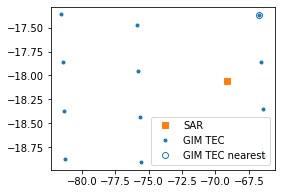

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20171029.txt.dt
distance to nearest TEC obs: 5.6 deg (605 km)


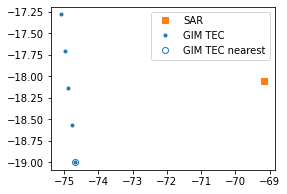

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20171110.txt.dt
distance to nearest TEC obs: 0.8 deg (91 km)


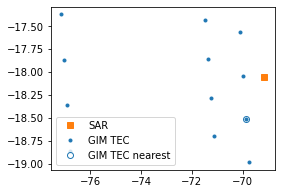

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20171122.txt.dt
distance to nearest TEC obs: 3.0 deg (320 km)


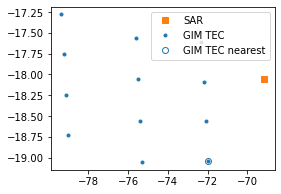

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20171204.txt.dt
distance to nearest TEC obs: 3.1 deg (338 km)


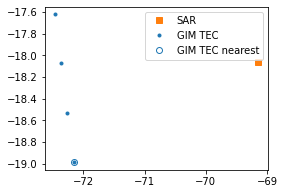

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20171216.txt.dt
distance to nearest TEC obs: 4.8 deg (520 km)


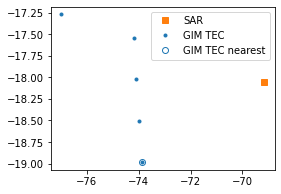

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20171228.txt.dt
distance to nearest TEC obs: 2.1 deg (231 km)


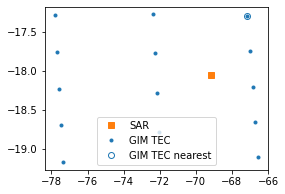

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180202.txt.dt
distance to nearest TEC obs: 6.0 deg (647 km)


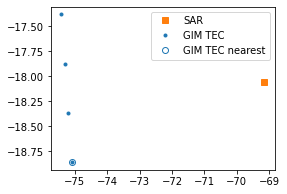

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180214.txt.dt
distance to nearest TEC obs: 3.5 deg (382 km)


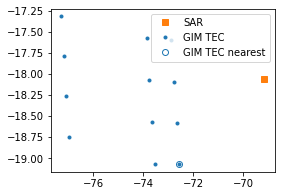

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180226.txt.dt
distance to nearest TEC obs: 1.8 deg (194 km)


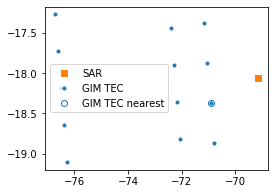

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180310.txt.dt
distance to nearest TEC obs: 10.7 deg (1157 km)


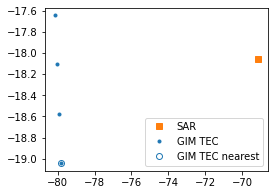

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180322.txt.dt
distance to nearest TEC obs: 4.8 deg (523 km)


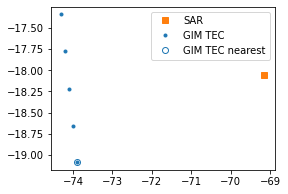

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180403.txt.dt
distance to nearest TEC obs: 5.2 deg (558 km)


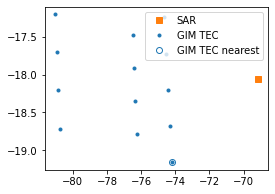

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180415.txt.dt
distance to nearest TEC obs: 4.9 deg (532 km)


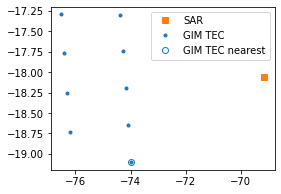

ERROR: no file found for 20180427 in: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180427.txt.dt
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180509.txt.dt
distance to nearest TEC obs: 1.1 deg (124 km)


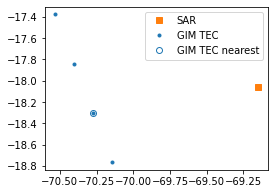

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180521.txt.dt
distance to nearest TEC obs: 1.9 deg (209 km)


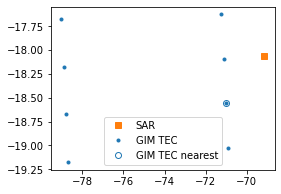

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180602.txt.dt
distance to nearest TEC obs: 8.8 deg (946 km)


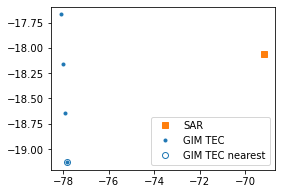

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180614.txt.dt
distance to nearest TEC obs: 5.2 deg (562 km)


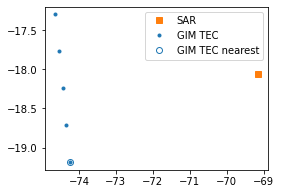

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180626.txt.dt
distance to nearest TEC obs: 1.9 deg (204 km)


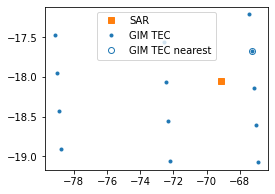

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180708.txt.dt
distance to nearest TEC obs: 1.6 deg (175 km)


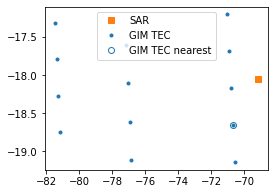

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180720.txt.dt
distance to nearest TEC obs: 6.7 deg (728 km)


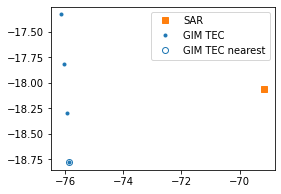

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180801.txt.dt
distance to nearest TEC obs: 3.5 deg (378 km)


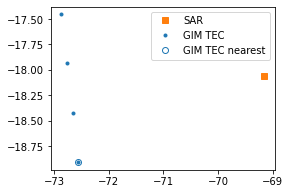

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180813.txt.dt
distance to nearest TEC obs: 1.5 deg (164 km)


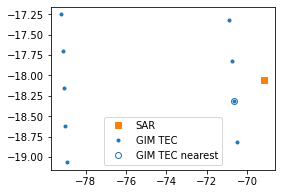

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180825.txt.dt
distance to nearest TEC obs: 9.4 deg (1015 km)


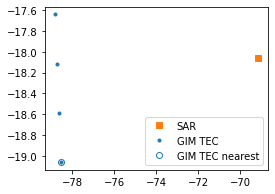

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180906.txt.dt
distance to nearest TEC obs: 8.5 deg (921 km)


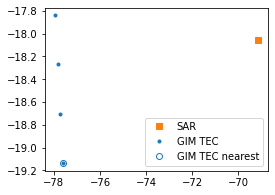

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180918.txt.dt
distance to nearest TEC obs: 0.4 deg (45 km)


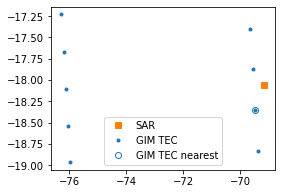

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20180930.txt.dt
distance to nearest TEC obs: 2.1 deg (224 km)


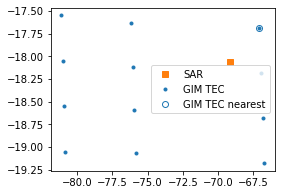

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20181012.txt.dt
distance to nearest TEC obs: 6.3 deg (677 km)


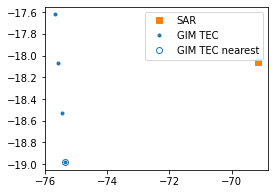

ERROR: no file found for 20181024 in: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20181024.txt.dt
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20181105.txt.dt
distance to nearest TEC obs: 2.7 deg (292 km)


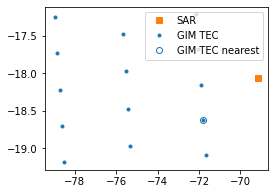

ERROR: no file found for 20181117 in: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20181117.txt.dt
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20181129.txt.dt
distance to nearest TEC obs: 6.0 deg (650 km)


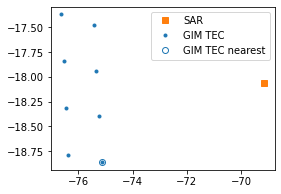

ERROR: no file found for 20181211 in: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20181211.txt.dt
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20181223.txt.dt
distance to nearest TEC obs: 1.3 deg (141 km)


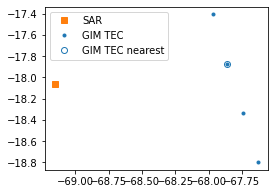

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190104.txt.dt
distance to nearest TEC obs: 5.0 deg (541 km)


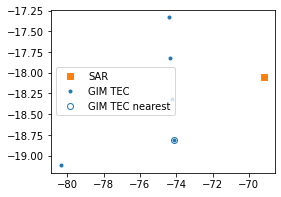

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190128.txt.dt
distance to nearest TEC obs: 0.1 deg (14 km)


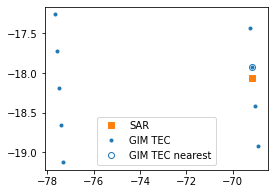

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190209.txt.dt
distance to nearest TEC obs: 2.1 deg (226 km)


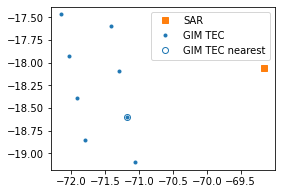

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190221.txt.dt
distance to nearest TEC obs: 0.2 deg (21 km)


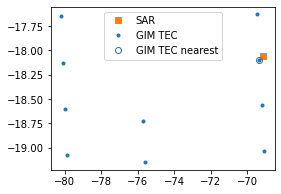

ERROR: no file found for 20190305 in: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190305.txt.dt
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190317.txt.dt
distance to nearest TEC obs: 4.7 deg (510 km)


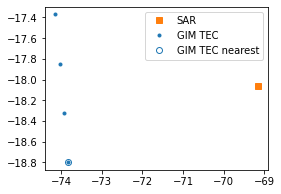

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190329.txt.dt
distance to nearest TEC obs: 4.5 deg (485 km)


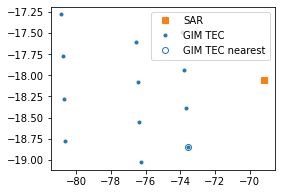

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190410.txt.dt
distance to nearest TEC obs: 6.8 deg (736 km)


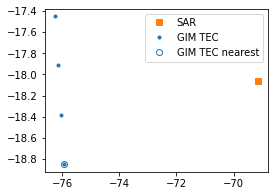

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190422.txt.dt
distance to nearest TEC obs: 1.0 deg (103 km)


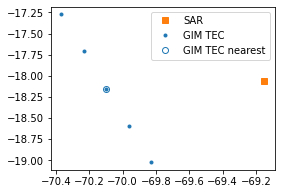

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190504.txt.dt
distance to nearest TEC obs: 2.0 deg (219 km)


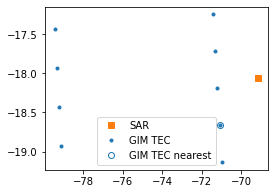

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190516.txt.dt
distance to nearest TEC obs: 2.2 deg (233 km)


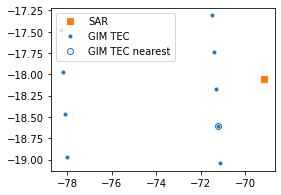

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190528.txt.dt
distance to nearest TEC obs: 5.6 deg (609 km)


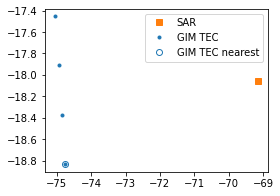

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190609.txt.dt
distance to nearest TEC obs: 2.6 deg (276 km)


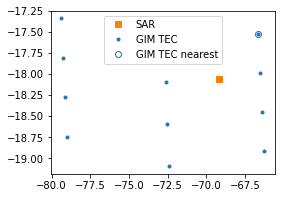

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190621.txt.dt
distance to nearest TEC obs: 1.8 deg (193 km)


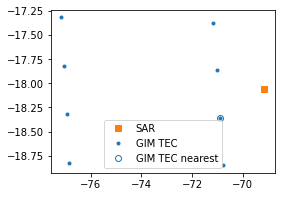

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190703.txt.dt
distance to nearest TEC obs: 6.6 deg (707 km)


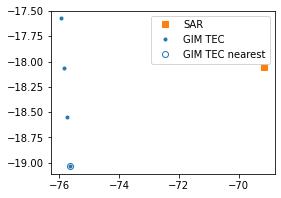

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190715.txt.dt
distance to nearest TEC obs: 4.4 deg (476 km)


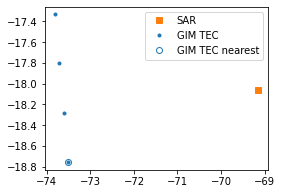

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190727.txt.dt
distance to nearest TEC obs: 2.3 deg (251 km)


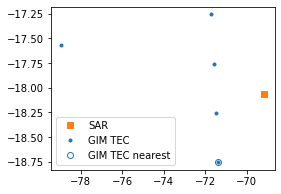

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190808.txt.dt
distance to nearest TEC obs: 0.4 deg (47 km)


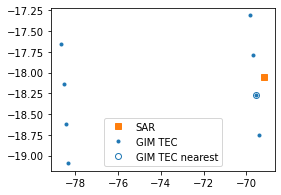

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190820.txt.dt
distance to nearest TEC obs: 8.7 deg (935 km)


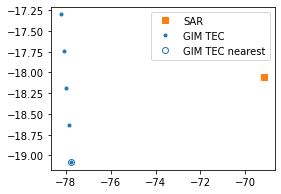

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190901.txt.dt
distance to nearest TEC obs: 1.6 deg (170 km)


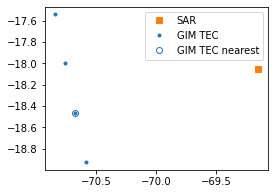

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20190913.txt.dt
distance to nearest TEC obs: 0.9 deg (97 km)


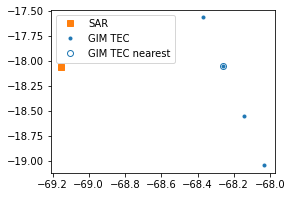

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20191007.txt.dt
distance to nearest TEC obs: 1.0 deg (108 km)


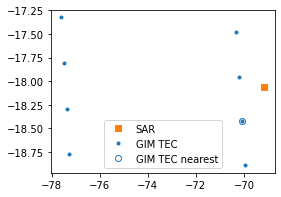

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20191019.txt.dt
distance to nearest TEC obs: 1.4 deg (148 km)


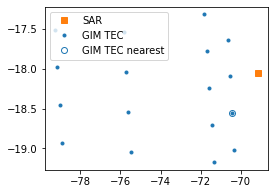

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20191031.txt.dt
distance to nearest TEC obs: 5.3 deg (572 km)


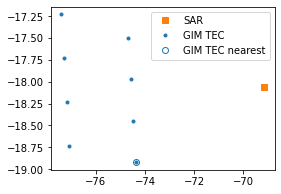

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20191112.txt.dt
distance to nearest TEC obs: 6.3 deg (685 km)


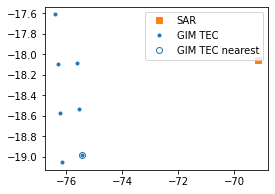

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20191124.txt.dt
distance to nearest TEC obs: 3.9 deg (418 km)


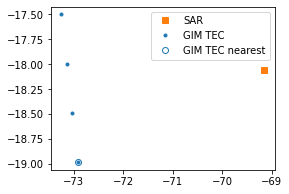

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20191206.txt.dt
distance to nearest TEC obs: 2.3 deg (244 km)


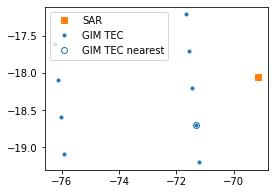

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20191218.txt.dt
distance to nearest TEC obs: 11.9 deg (1283 km)


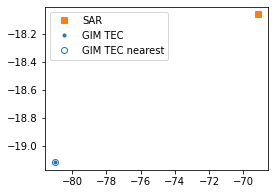

read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20191230.txt.dt
distance to nearest TEC obs: 4.3 deg (467 km)


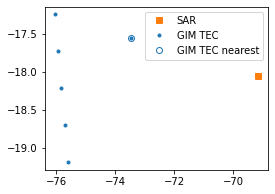

ERROR: no file found for 20200111 in: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20200111.txt.dt
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20200123.txt.dt
distance to nearest TEC obs: 1.9 deg (208 km)


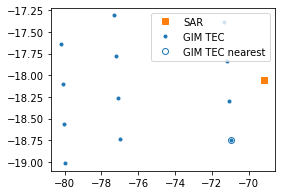

ERROR: no file found for 20200216 in: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20200216.txt.dt
read JPL GIM TEC data from file: /Users/yunjunz/data/archives/ChileSenAT149/tec_sent1_tracks/subtec_sent1_20200228.txt.dt
distance to nearest TEC obs: 5.1 deg (549 km)


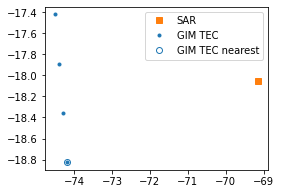

In [7]:
## calculate the vertical TEC
ts_file = os.path.join(mintpy_dir, 'timeseriesRg.h5')
date_list_all = timeseries(ts_file).get_date_list()

date_list = []
vtec_total_list = []
vtec_downside_list = []
vtec_topside_list = []
ipp_lat_list = []
ipp_lon_list = []
dist_list = []

for date_str in date_list_all:
    (vtec_total,
     vtec_downside,
     vtec_topside,
     ipp_lat,
     ipp_lon,
     dist) = iono.get_gim_tec_value(gim_tec_dir, date_str, lat, lon, display=True)

    if vtec_total is not None:
        date_list.append(date_str)
        vtec_total_list.append(vtec_total)
        vtec_downside_list.append(vtec_downside)
        vtec_topside_list.append(vtec_topside)
        ipp_lat_list.append(ipp_lat)
        ipp_lon_list.append(ipp_lon)
        dist_list.append(dist)



### 2. save to pickle file

In [8]:
# gather all into gim_tec dict
gim_tec = {}
gim_tec['date'] = np.array(date_list)
gim_tec['time'] = np.array(ptime.date_list2vector(date_list)[0])
gim_tec['vtec_total'] = np.array(vtec_total_list)
gim_tec['vtec_downside'] = np.array(vtec_downside_list)
gim_tec['vtec_topside'] = np.array(vtec_topside_list)
gim_tec['ipp_lat'] = np.array(ipp_lat_list)
gim_tec['ipp_lon'] = np.array(ipp_lon_list)
gim_tec['distance'] = np.array(dist_list)

## calculate the predicted range delay
# L-band: 1.2575 GHz (ALOS2, NISAR-L)
# S-band: 3.2 GHz (NISAR-S)
# C-band: 5.405 GHz (Sentinel-1)
for band, freq in zip(['Cband', 'Sband', 'Lband'],
                      [5.405e9, 3.2e9, 1.2575e9]):
    for side in ['total', 'downside', 'topside']:
        key_off = 'range_delay4{b}_tec_{s}'.format(b=band, s=side)
        key_tec = 'vtec_{s}'.format(s=side)
        print('calc {:<32} from {:<15}'.format(key_off, key_tec))
        gim_tec[key_off] = iono.vtec2range_delay(gim_tec[key_tec], inc_angle, freq=freq)

## save to file
with open(out_file, 'wb') as f:
    pickle.dump(gim_tec, f)
    print('save data to file: {}'.format(out_file))

calc range_delay4Cband_tec_total      from vtec_total     
calc range_delay4Cband_tec_downside   from vtec_downside  
calc range_delay4Cband_tec_topside    from vtec_topside   
calc range_delay4Sband_tec_total      from vtec_total     
calc range_delay4Sband_tec_downside   from vtec_downside  
calc range_delay4Sband_tec_topside    from vtec_topside   
calc range_delay4Lband_tec_total      from vtec_total     
calc range_delay4Lband_tec_downside   from vtec_downside  
calc range_delay4Lband_tec_topside    from vtec_topside   
save data to file: /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_gim_tec.pickle


### 3. plot

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_gim_tec.png


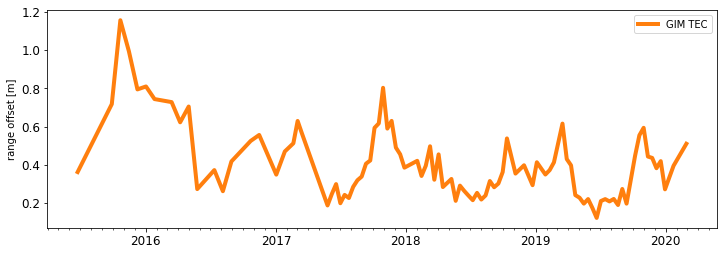

In [10]:
## plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(gim_tec['time'], gim_tec['range_delay4Cband_tec_total'], linewidth=4, color='C1', label='GIM TEC')
pp.auto_adjust_xaxis_date(ax, gim_tec['time'], every_year=1, buffer_year=None)
ax.set_ylabel('range offset [m]')
plt.legend()

# output
out_fig = os.path.join(mintpy_dir, 'TS_gim_tec.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()